|Phase|Sub Phase|Description|Public Score|
|:---:|:-------:|:---------:|:----------:|
|1 | 1| Cat Boost Model trained on categorical data with no optimization |0.88005|
|1| 2| Cat Boost Model trained on categorical data with optimized catboost params from other nbs|0.88095|

In [ ]:
# Importing generic libraries
import pandas as pd
import numpy as np
import os
import re

# Importing visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import sklearn module
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,
                             classification_report)

#Importing other libraries
from imblearn.over_sampling import SMOTE

#Importing Boost Classification Libraries
from catboost import CatBoostClassifier, Pool

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')

print(len(train))
print(len(test))

train.head()

11504798
7669866


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


Text(0.5, 1.0, 'Checking Imbalance in Training Data Or Response')

<Figure size 600x600 with 0 Axes>

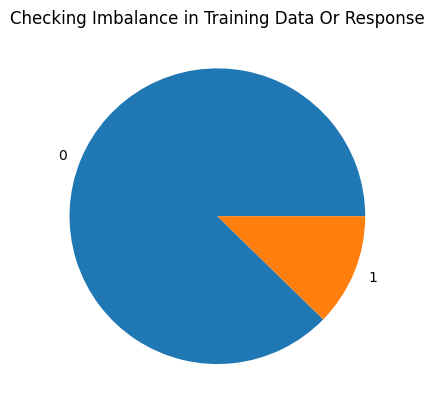

In [ ]:
#Checking If training data is Imbalanced
response_data = train['Response'].value_counts()
plt.figure(figsize=(6,6))
fig, ax = plt.subplots()
ax.pie(response_data, labels = [0,1])
ax.set_title('Checking Imbalance in Training Data Or Response')

In [ ]:
len(train[train['Response']==1])/len(train)

0.12299729208631043

In [ ]:
train['Gender'] = np.where(train['Gender']=='Male',1,0)
test['Gender'] = np.where(test['Gender']=='Male',1,0)

train['Vehicle_Damage'] = np.where(train['Vehicle_Damage']=='Yes',1,0)
test['Vehicle_Damage'] = np.where(test['Vehicle_Damage']=='Yes',1,0)

train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1,21,1,35.0,0,1-2 Year,1,65101.0,124.0,187,0
1,1,1,43,1,28.0,0,> 2 Years,1,58911.0,26.0,288,1
2,2,0,25,1,14.0,1,< 1 Year,0,38043.0,152.0,254,0
3,3,0,35,1,1.0,0,1-2 Year,1,2630.0,156.0,76,0
4,4,0,36,1,15.0,1,1-2 Year,0,31951.0,152.0,294,0


In [ ]:
train['prefix'] = 'RC_'
test['prefix'] = 'RC_'
train['cat_Region_Code'] = train['prefix'] + train['Region_Code'].astype('int').astype('str')
test['cat_Region_Code'] = test['prefix'] + test['Region_Code'].astype('int').astype('str')


train['prefix'] = 'PSC_'
test['prefix'] = 'PSC_'
train['cat_Policy_Sales_Channel'] = train['prefix'] + train['Policy_Sales_Channel'].astype('int').astype('str')
test['cat_Policy_Sales_Channel'] = test['prefix'] + test['Policy_Sales_Channel'].astype('int').astype('str')

train['prefix'] = 'Vin_'
test['prefix'] = 'Vin_'
train['cat_Vintage'] = train['prefix'] + train['Vintage'].astype('int').astype('str')
test['cat_Vintage'] = test['prefix'] + test['Vintage'].astype('int').astype('str')

train = train.drop(columns = ['prefix'])
test = test.drop(columns = ['prefix'])

train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,cat_Region_Code,cat_Policy_Sales_Channel,cat_Vintage
0,0,1,21,1,35.0,0,1-2 Year,1,65101.0,124.0,187,0,RC_35,PSC_124,Vin_187
1,1,1,43,1,28.0,0,> 2 Years,1,58911.0,26.0,288,1,RC_28,PSC_26,Vin_288
2,2,0,25,1,14.0,1,< 1 Year,0,38043.0,152.0,254,0,RC_14,PSC_152,Vin_254
3,3,0,35,1,1.0,0,1-2 Year,1,2630.0,156.0,76,0,RC_1,PSC_156,Vin_76
4,4,0,36,1,15.0,1,1-2 Year,0,31951.0,152.0,294,0,RC_15,PSC_152,Vin_294


In [ ]:
cat_columns = ['cat_Region_Code','cat_Policy_Sales_Channel','cat_Vintage','Vehicle_Age']

### Phase I Training Catboost and LGBM using categorical features

1. The first trial is training with no further data wrangling and no further hyper-parameter optimization

In [ ]:
# df_train = train.iloc[: 2 * len(train) // 3]
# df_test = train.iloc[2 * len(train) // 3 :]
# train_pool = Pool(df_train.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']),
#                   label=df_train.Response,
#                   cat_features=cat_columns)
# test_pool = Pool(df_test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']),
#                  label=df_test.Response,
#                  cat_features=cat_columns)

In [ ]:
# Model Params 1.1

# catboost_params = {
#     'loss_function' : 'Logloss',
#     'eval_metric' : 'AUC',
#     'verbose' : 2000,
#     'random_seed' : 42,
#     'custom_metric' : 'AUC:hints=skip_train~false',
#     'n_estimators' : 1000,
#     'task_type' : "GPU"
# }


# Model Params 1.2, 2.1

catboost_params = {
     'loss_function':'Logloss',
     'eval_metric':'AUC',
     'learning_rate':0.05,
     'depth':9,
     'random_strength':0,
     'l2_leaf_reg':0.5,
     'task_type':'GPU',
     'random_seed':42,
     'verbose' : 1000,
     'early_stopping_rounds':200
 }

# cat_model = CatBoostClassifier(**catboost_params)
# cat_model.fit(train_pool, eval_set=test_pool, use_best_model = True, plot=True)

In [ ]:
# cat_train_pred = cat_model.predict_proba(df_train.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']))[:,1]
# cat_test_pred = cat_model.predict_proba(df_test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']))[:,1]
# print(roc_auc_score(df_train.Response,cat_train_pred))
# print(roc_auc_score(df_test.Response,cat_test_pred))

### Phase II Sampling

In [ ]:
df_train = train.iloc[: 4 * len(train) // 5]
df_test = train.iloc[4 * len(train) // 5 :]
test_pool = Pool(df_test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']),
                 label=df_test.Response,
                 cat_features=cat_columns)
oversample = df_train[df_train['Response']==1]
num = len(oversample)

cat_train_pred = []
cat_test_pred = []
test_pred = []

for i in range(1):
    undersample = df_train[df_train['Response']==0]
    undersample = undersample.sample(n = num, random_state = 42)
    train_df = pd.concat([oversample,undersample]).sample(frac = 1,
                                                         random_state = 42).reset_index().drop(columns = ['index'])
    train_pool = Pool(train_df.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']),
                  label=train_df.Response,
                  cat_features=cat_columns)
    cat_model = CatBoostClassifier(**catboost_params)
    cat_model.fit(train_pool, eval_set=test_pool, use_best_model = True, plot=True)
    cat_train_pred.append(cat_model.predict_proba(train_df.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']))[:,1])
    cat_test_pred.append(cat_model.predict_proba(df_test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']))[:,1])
    test_pred.append(cat_model.predict_proba(test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage']))[:,1])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8632886	best: 0.8632886 (0)	total: 456ms	remaining: 7m 35s
999:	test: 0.8802785	best: 0.8802785 (999)	total: 6m 14s	remaining: 0us
bestTest = 0.8802784681
bestIteration = 999


CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=10]="Vin_197": Cannot convert 'b'Vin_197'' to float

In [ ]:
for i in range(1):
    cat_train_pred.append(cat_model.predict_proba(train_df.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']))[:,1])
    cat_test_pred.append(cat_model.predict_proba(df_test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage','Response']))[:,1])
    test_pred.append(cat_model.predict_proba(test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage']))[:,1])
    print(f'For model {i} the ROC AUC Scores are as follows:')
    print(f"The roc auc score for training data is: {roc_auc_score(train_df['Response'],cat_train_pred[i])}")
    print(f"The roc auc score for test data is: {roc_auc_score(df_test['Response'],cat_test_pred[i])}")

For model 0 the ROC AUC Scores are as follows:
The roc auc score for training data is: 0.8839069971498734
The roc auc score for test data is: 0.8802783888783805


In [ ]:
# test_pred = cat_model.predict_proba(test.drop(columns = ['id','Region_Code','Policy_Sales_Channel','Vintage']))[:,1]
# sample_submission['Response'] = test_pred
sample_submission['Response'] = test_pred[i]
sample_submission.to_csv('catboost_cat_no_optimization.csv', index = False)
sample_submission.head()

,id,Response
0,11504798,0.040379
1,11504799,0.840616
2,11504800,0.695931
3,11504801,0.000848
4,11504802,0.270128
